In [3]:
%%capture --no-stderr
%pip install -U langchain langgraph langchain_openai langchain_experimental

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
embedchain 0.1.122 requires langchain<=0.3,>0.2, but you have langchain 0.3.7 which is incompatible.
embedchain 0.1.122 requires langchain-community<0.3.0,>=0.2.6, but you have langchain-community 0.3.5 which is incompatible.
embedchain 0.1.122 requires langchain-openai<0.2.0,>=0.1.7, but you have langchain-openai 0.2.6 which is incompatible.

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import getpass
import os

def set_if_undefined(var: str):
    if var not in os.environ:  # Check if the specific variable is undefined
        os.environ[var] = getpass.getpass(f"Please enter the {var} key: ")

set_if_undefined('OPENAI_API_KEY')
set_if_undefined('TAVILY_API_KEY')

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "lsv2_pt_f"
os.environ["LANGCHAIN_PROJECT"] = "Multi Agent"

### Creating Research Team Tools

In [22]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### Document Writing team Tools

In [23]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

_TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(_TEMP_DIRECTORY.name)


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"


### Helper Utilities

Creating a worker agent and create a supervisor for the subgraph

In [24]:
from typing import List, Optional
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

from langgraph.graph import END, StateGraph, START
from langchain_core.messages import HumanMessage, trim_messages

llm = ChatOpenAI(model="gpt-4o-mini")

trimmer = trim_messages(
    max_tokens=100000,
    strategy="last",
    token_counter=llm,
    include_system=True,
)


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | trimmer
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

### Defining Agent Teams

#### Research Team

In [25]:
import functools
import operator

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# ResearchTeam graph state
class ResearchTeamState(TypedDict):
    # A message is added after each team member finishes
    messages: Annotated[List[BaseMessage], operator.add]
    # The team members are tracked so they are aware of
    # the others' skill-sets
    team_members: List[str]
    # Used to route work. The supervisor calls a function
    # that will update this every time it makes a decision
    next: str


llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = functools.partial(agent_node, agent=search_agent, name="Search")

research_agent = create_react_agent(llm, tools=[scrape_webpages])
research_node = functools.partial(agent_node, agent=research_agent, name="WebScraper")

supervisor_agent = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Search", "WebScraper"],
)

###### Now that we have defined each part of the graph. Add nodes to the graph and add edges between them to determine the transition criteria

In [26]:
research_graph = StateGraph(ResearchTeamState)
research_graph.add_node("Search", search_node)
research_graph.add_node("WebScraper", research_node)
research_graph.add_node("supervisor", supervisor_agent)

# Define the control flow
research_graph.add_edge("Search", "supervisor")
research_graph.add_edge("WebScraper", "supervisor")
research_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {"Search": "Search", "WebScraper": "WebScraper", "FINISH": END},
)


research_graph.add_edge(START, "supervisor")
chain = research_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str):
    results = {
        "messages": [HumanMessage(content=message)],
    }
    return results


research_chain = enter_chain | chain

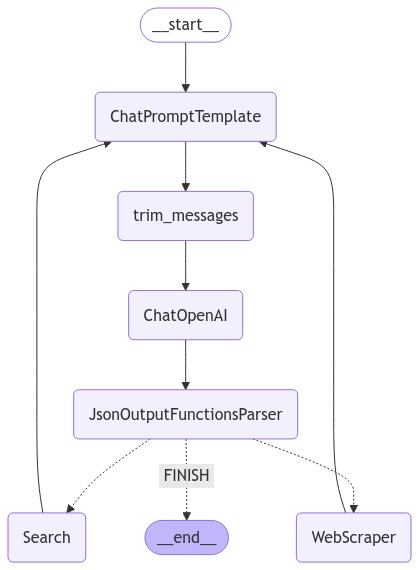

In [27]:
from IPython.display import Image, display

display(Image(chain.get_graph(xray=True).draw_mermaid_png()))

In [28]:
for s in research_chain.stream(
    "when is the taylor swift's next tour?",{"recursion_limit": 100}
):
    print(s)
    print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='Taylor Swift\'s "The Eras Tour" is currently ongoing, with additional U.S. tour dates announced for 2024. The tour showcases songs from every era of her career, with performances in various stadiums. If you\'re interested in attending a concert or learning more about specific dates, you might want to check official ticketing websites or Taylor Swift\'s official website for the most up-to-date information.', additional_kwargs={}, response_metadata={}, name='Search')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


#### Document Writing Team

In [30]:
import operator
from pathlib import Path


# Document writing team graph state
class DocWritingState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who to work next
    next: str
    # This tracks the shared directory state
    current_files: str


# This will be run before each worker agent begins work
# It makes it so they are more aware of the current state
# of the working directory.
def prelude(state):
    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir()
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
        ]
    except Exception:
        pass
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }


llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm, tools=[write_document, edit_document, read_document]
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

note_taking_agent = create_react_agent(llm, tools=[create_outline, read_document])
context_aware_note_taking_agent = prelude | note_taking_agent
note_taking_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="NoteTaker"
)

chart_generating_agent = create_react_agent(llm, tools=[read_document, python_repl])
context_aware_chart_generating_agent = prelude | chart_generating_agent
chart_generating_node = functools.partial(
    agent_node, agent=context_aware_note_taking_agent, name="ChartGenerator"
)

doc_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "NoteTaker", "ChartGenerator"],
)

We have all the objects now, let us create the graph

In [33]:
# Create the graph here:
# Note that we have unrolled the loop for the sake of this doc
authoring_graph = StateGraph(DocWritingState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("NoteTaker", note_taking_node)
authoring_graph.add_node("ChartGenerator", chart_generating_node)
authoring_graph.add_node("supervisor", doc_writing_supervisor)

# Add the edges that always occur
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("NoteTaker", "supervisor")
authoring_graph.add_edge("ChartGenerator", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "NoteTaker": "NoteTaker",
        "ChartGenerator": "ChartGenerator",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# We reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)


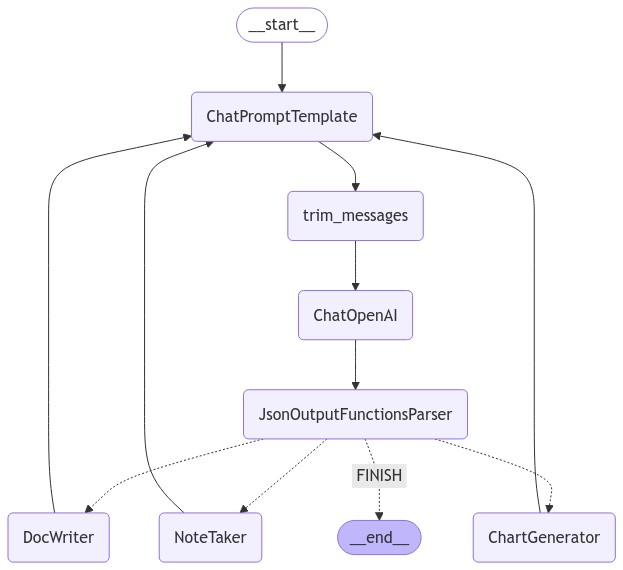

In [34]:
from IPython.display import display, Image
display(Image(chain.get_graph(xray = True).draw_mermaid_png()))

In [35]:
for s in authoring_chain.stream(
    "Write an outline for poem and then write the poem to disk.",
    {"rescursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'DocWriter'}}
---
{'DocWriter': {'messages': [HumanMessage(content='I have created the outline for the poem "Whispers of the Night" and saved it to a file named [poem_outline.txt](sandbox:/poem_outline.txt). The poem itself has been written and saved to a file named [poem.txt](sandbox:/poem.txt).', additional_kwargs={}, response_metadata={}, name='DocWriter')]}}
---
{'supervisor': {'next': 'FINISH'}}
---


### Adding Layers
Since we have the research_graph and writing_graph separately, we will be adding layers to orchestrate the workflow between the both of them

We will create a third graph for that and add cinnectors to define this top level state is shared between different graphs

In [41]:
from langchain_core.messages import BaseMessage
from langchain_openai.chat_models import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

supervisor_node = create_team_supervisor(
    llm,
    """You are a supervisor tasked with managing the conversation between the 
    following teams: {team_members}. Given the following user request, respond 
    with the worker to act next. Each worker will perform a task and respond with 
    their results and status. When finished, respond with FINISH.""",
    ["ResearchTeam", "PaperWritingTeam"],
)

In [42]:
#Top level graph state
class State(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]
    next: str

def get_last_message(state: State) -> str:
    return state["messages"][-1].content

def join_graph(response: dict):
    return {"messages": [response["messages"][-1]]}

#Define the graph
super_graph = StateGraph(State)
#First add the nodes which will do the same work
super_graph.add_node("ResearchTeam", get_last_message | research_chain | join_graph)
super_graph.add_node("PaperWritingTeam",get_last_message|authoring_chain|join_graph)
super_graph.add_node("supervisor",supervisor_node)

#Define the graph connections to control the logic thorugh the flow
super_graph.add_edge("ResearchTeam","supervisor")
super_graph.add_edge("PaperWritingTeam","supervisor")
super_graph.add_conditional_edges(
    "supervisor",
    lambda x:x["next"],
    {
        "ResearchTeam":"ResearchTeam",
        "PaperWritingTeam":"PaperWritingTeam",
        "FINISH":END
        },
     )
super_graph.add_edge(START,"supervisor")
super_graph = super_graph.compile()

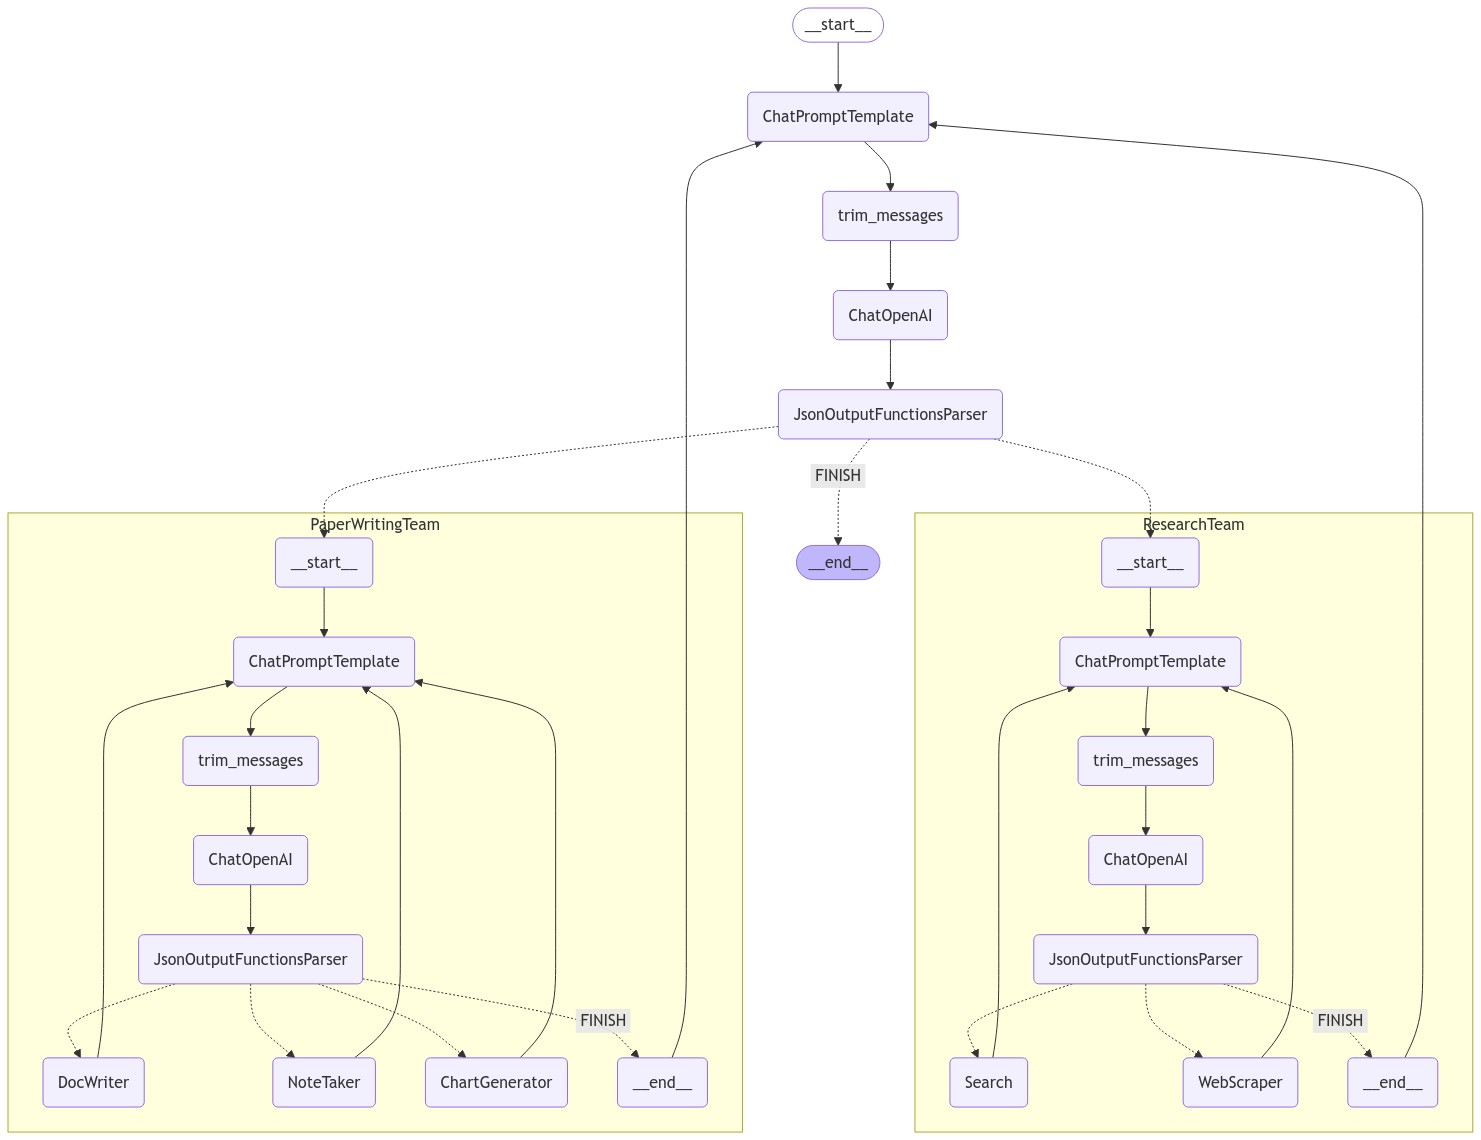

In [43]:
from IPython.display import Image, display

display(Image(super_graph.get_graph(xray=True).draw_mermaid_png()))

In [44]:
for s in super_graph.stream(
    {
        "messages": [
            HumanMessage(
                content  = "Write a brief research report on the North American sturgeon. Include a chart"
            )
        ]
    },
    {"recursion_limit" : 150},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'ResearchTeam'}}
---
{'ResearchTeam': {'messages': [HumanMessage(content='## Research Report: North American Sturgeon\n\n### Introduction\nSturgeons are ancient fish species known for their unique appearance, large size, and long lifespan. In North America, several species of sturgeon are found across various habitats, from coastal areas to freshwater rivers and lakes. These species are vital from ecological, economic, and conservation perspectives.\n\n### North American Sturgeon Species\nThe three notable species of sturgeon in North America include:\n\n1. **Atlantic Sturgeon (*Acipenser oxyrinchus oxyrinchus*)**: \n   - **Habitat**: Found in rivers and coastal waters from Maine to Florida. \n   - **Conservation Status**: Listed as endangered or threatened under the Endangered Species Act (ESA) in the United States.\n   - **Threats**: Entanglement in fishing gear, habitat degradation, vessel strikes.\n\n2. **Green Sturgeon (*Acipenser medirostris*)**:\n   - **H